### Create the process for identifying new polygons for site points that don't have one

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import folium

# use these if you are using the pandas dataframe view, I prefer itables because it is interactive
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# this makes dataframes viewable as interactive tables with search and sort
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

import itables.options as opt
opt.maxBytes = 0 ### this removes size limits for interactive table


<IPython.core.display.Javascript object>

#### ** helpful links and snippets

In [2]:
# os.getcwd() # check what the working directory is

# keyboard shortcuts
# https://noteable.io/blog/jupyter-notebook-shortcuts-boost-productivity/
# os.chdir('/Users/sarahodges/spatial/SAVI/hudson_access/data/published')
os.chdir('/Users/saraeichner/Desktop/github/hap')

An anti-join allows you to return all rows in one dataset that do not have matching values in another dataset. You can use the following syntax to perform an anti-join between two pandas DataFrames: outer = df1. merge(df2, how='outer', indicator=True) anti_join = outer[(outer._merge=='left_only')].

In [44]:
# antijoin
sites_no_update = site_points_df.merge(updated_sites[['site_id']], how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis="columns")

### test to determine if the antijoin worked as predicted, should == 0
len(site_points_df) - len(replaced_sites) - len(sites_no_update)

0

In [45]:
new_hap_site_points_temp = pd.concat([sites_no_update, updated_sites], ignore_index=True)

#### checks

len(new_hap_site_points_temp)
# 750, good, it removed the dupe in the og data

750

## concat example

* * * * * * * 
* * * * * * * 

## add polygons for new sites
- hap potential site polys (this is in hap dropbox, merged data)
- updated site points (from above, or github)
#### then add those new polys to current HAP site polygons

In [23]:
# local github repo path, 
# st_pts = site points
# pot_polys = potential polygons
# st_polys = site polygons
st_pts_path = ('/Users/saraeichner/Desktop/github/hap/data/hap_site_points_20230804.geojson')
st_pts = gpd.read_file(st_pts_path)
# potential polygons updated 8/16 with code below this process in this script (new_potential_polygons)
pot_polys_path = ('/Users/saraeichner/Dropbox/hudson_access_project/hap_data/merged_site_data/potential_site_polygons_08162023.geojson')
pot_polys = gpd.read_file(pot_polys_path)
st_polys_path = ('/Users/saraeichner/Dropbox/hudson_access_project/hap_data/merged_site_data/current/as_published/hap_site_poly.geojson')
st_polys = gpd.read_file(st_polys_path)

In [205]:
# pot_polys = new_potential_polygons

### review the data, check for gaps, see how new points overlap with potential polys

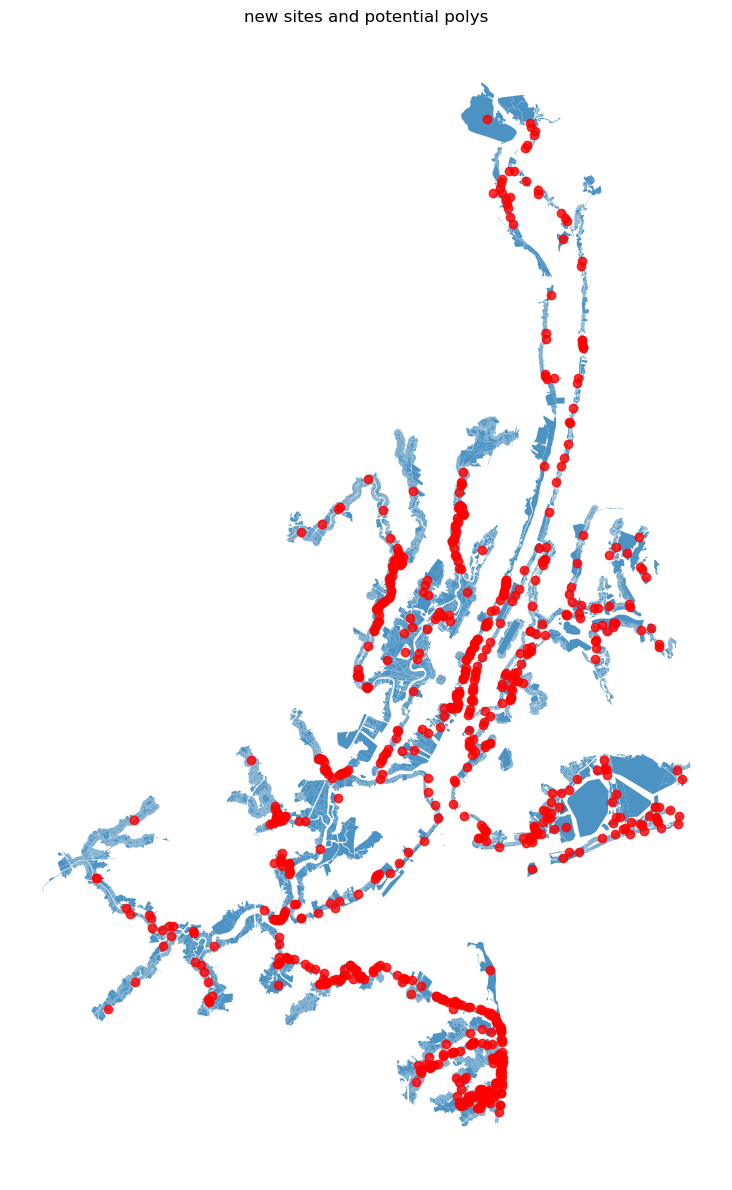

In [131]:
# plot to see how much overlap there is between the two gdfs
# new_potential_polygons
fig, ax = plt.subplots(figsize = (12,12))

st_pts.plot(ax = ax, marker_size = 2, color = 'black', alpha = .8, zorder = 2)
pot_polys.plot(ax = ax, alpha = .8, zorder = 1)

ax.axis('off')
plt.title('new sites and potential polys');
fig.tight_layout()
#plt.savefig('/Users/saraeichner/Dropbox/hudson_access_project/gis/poly_processing/plots/missing_pot_polys.pdf')

1. find all site points that don't intersect with a polygon

### find the polygons that do not intersect with a site polygon
- some of these have a nearby polygon
- ignoring that for now in case this process finds one closer since filling tax lot gaps
- if none are found, the original nearest poly will be retained

In [132]:
# find all stpts that are within a st_poly
st_pts['has_poly'] = st_pts['geometry'].intersects(st_polys.unary_union)
st_pts['has_poly'] = st_pts['has_poly'].astype(int)
st_pts['has_poly'].value_counts()

1    675
0     88
Name: has_poly, dtype: int64

### subset site points to only those without a polygon
- this will be a mix of old and new

In [133]:
# subset st_pts to those that need a polygon or where 'has_poly' is 0
need_poly = st_pts[st_pts['has_poly'] == 0]
need_poly.head()

site_id       act_codes                                   access_id  \
1       29  MPBL,HPBL,FISH                         126, 83, 1613, 1803   
5       10  FISH,MPBL,HPBL  18, 358, 416, 051, 667, 100, 000, 000, 000   
17     114       HPBL,FISH                            1, 514, 181, 748   
21     119       MPBL,HPBL                                 4, 991, 670   
25     122            FISH                                         223   

                                            site_name site_label  \
1                               Conference House Park       None   
5   Flushing Bay Promenade, Flushing Meadows Coron...       None   
17  East River Esplanade and Bikeway (E 90th St - ...       None   
21                     Sherman Creek Street End Parks       None   
25                        Harlem River Drive Greenway       None   

                                         site_address  \
1   Hylan Blvd & Satterlee St, Staten Island, Hyla...   
5   12500 Northern Blvd, Corona, NY 11368; Flushin...   
17         E 96th St, Manhattan, FDR Dr near 107th St   
21                          W 202nd St End, Manhattan   
25                 FDR Dr between 125th and 145th Sts   

                                     site_description  \
1   The site of a legendary display of American de...   
5                                                None   
17                                               None   
21                                               None   
25                                               None   

                                           hours_info open_close_date   fee  \
1           Sunrise to Sunset (April 1 to December 1)            None     Y   
5   Mon-Fri 11:00 AM-7:00 PM; Sat-Sun 10:00 AM-7:0...            None  None   
17                                               None            None  None   
21                                               None            None  None   
25                                               None            None  None   

   fee_amount public_transit  \
1        None              Y   
5        None              Y   
17       None              Y   
21       None              Y   
25       None              Y   

                           public_transit_description  \
1   S59, S78, X17, X22, X22A bus to Hylan Blvd, Cr...   
5   Subway: 7, Q19/Q48 Bus to 108th St, Astoria Bl...   
17                Subway: Q; M106 Bus to 105st/FDR Dr   
21         Subway: 1; Metro North: University Heights   
25  Subway: 2, 3, 4, 5, 6, A, B, C, D; M1 Bus but ...   

                                           url_public  phone_public  \
1                    www.dec.ny.gov/outdoor/8377.html          None   
5   www.nycgovparks.org/facilities/kayak/14, www.d...  718-478-0480   
17                   www.dec.ny.gov/outdoor/8377.html          None   
21            www.nycgovparks.org/facilities/kayak/27          None   
25                                               None          None   

                          email_public     site_manager phone_site_manager  \
1                                 None             None               None   
5   rpryor@guardiansofflushingbay.org,  Laurie Howard\n               None   
17                                None    Scott Alwin\n               None   
21                  info@govisland.org             None               None   
25                                None             None               None   

            email_site_manager access_type access_type_other  \
1                         None        None              None   
5   rownorthjersey@optimum.net        None              None   
17         sa2559@columbia.edu        None              None   
21                        None        None              None   
25                        None        None              None   

   accessibility_description  \
1                       None   
5                       None   
17                      None   
21                      None   
25         

In [134]:
# subset need_poly to columns with info we need in the polygons: 'site_id', 'site_name', 'act_codes', geometry
need_poly_join=need_poly[['site_id','site_name','act_codes','geometry']]

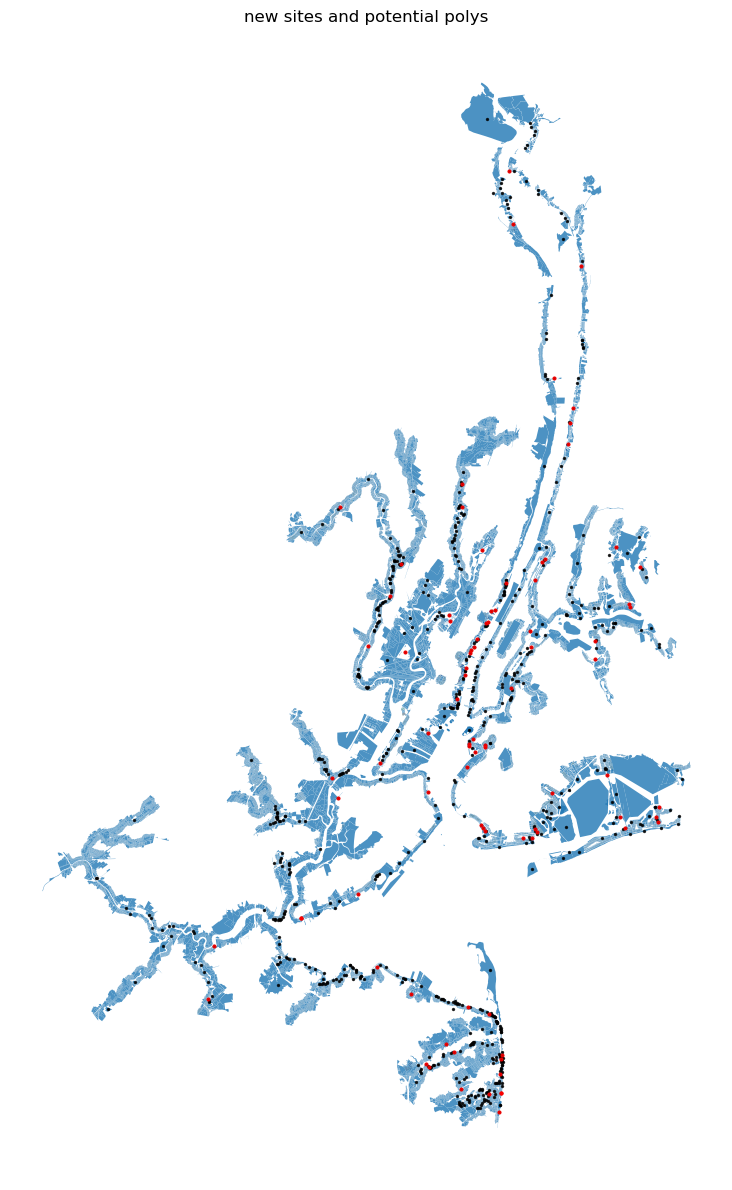

In [136]:
# plot to see how much overlap there is between the two gdfs
# new_potential_polygons
fig, ax = plt.subplots(figsize = (12,12))
need_poly_join.plot(ax = ax, markersize = 4, color = 'red', alpha = .8, zorder = 3)
st_pts.plot(ax = ax, markersize = 2, color = 'black', alpha = .8, zorder = 2)
pot_polys.plot(ax = ax, alpha = .8, zorder = 1)

ax.axis('off')
plt.title('new sites and potential polys');
#plt.savefig('/Users/saraeichner/Dropbox/hudson_access_project/gis/poly_processing/plots/missing_pot_polys.pdf')

In [47]:
# backup the site points wihtout polygons (need_poly_join) as shape file
need_poly_join.to_file("/Users/saraeichner/Desktop/github/hap/data/pts_need_polys.shp")

In [137]:
need_poly_join.head()

site_id                                          site_name       act_codes  \
1       29                              Conference House Park  MPBL,HPBL,FISH   
5       10  Flushing Bay Promenade, Flushing Meadows Coron...  FISH,MPBL,HPBL   
17     114  East River Esplanade and Bikeway (E 90th St - ...       HPBL,FISH   
21     119                     Sherman Creek Street End Parks       MPBL,HPBL   
25     122                        Harlem River Drive Greenway            FISH   

                      geometry  
1   POINT (-74.24052 40.50140)  
5   POINT (-73.85082 40.76124)  
17  POINT (-73.93661 40.78917)  
21  POINT (-73.91771 40.86126)  
25  POINT (-73.93052 40.83994)

In [128]:
new_potential_polygons.head()

site_name act_codes address site_id hap_site dataset name owner_tax  match  \
0         0         0       0       0        0       0    0         0    0.0   
1         0         0       0       0        0       0    0         0    0.0   
2         0         0       0       0        0       0    0         0    0.0   
3         0         0       0       0        0       0    0         0    0.0   
4         0         0       0       0        0       0    0         0    0.0   

                                            geometry  
0  POLYGON ((-73.92498 41.31157, -73.92500 41.311...  
1  POLYGON ((-73.92604 41.31115, -73.92729 41.311...  
2  POLYGON ((-73.92541 41.31062, -73.92611 41.311...  
3  POLYGON ((-73.92630 41.31082, -73.92652 41.310...  
4  POLYGON ((-73.92652 41.31061, -73.92704 41.310...

### testing which intersection methods are best for this process: Unary Union or SJoin (left, or inner?)
1. add a column to potential polygons to indcate that it is a HAP_site_polygon by intersecting iwth new site points
2. join the attributes of those points to the potential polygons
3. each method requires more steps 
4. best might be to do the sjoin, left and then go back to copy data from joined columns (left and right duplicates) into original column, remove suffix, adn drop the extra columns. 
5. also subset to the new polygons to add to HAP site polys

### unary union
does not join all the attribute data but adds a boolean field with true or false re. overlap. 

In [201]:
# find all pot_polys polygons that intersect with 'need_poly' points and create a new gdf
# then merge or add those polygons with the st_polys gdf
#pot_polys['add_to_hap_polys'] =  pot_polys['geometry'].within(need_poly_join.unary_union.buffer(200))
pot_polys_test = pot_polys
pot_polys_test['add_to_hap_polys'] = pot_polys_test['geometry'].intersects(need_poly_join.unary_union)
 #add_to_hap_polys_test = pot_polys[pot_polys['add_to_hap_polys'] == True]
pot_polys_test.head()
# len(add_to_hap_polys) # 21
# fixing the polygon dataset means we captured 3 more polygons for new site points (or old ones that didn't have one before)

site_name act_codes address site_id hap_site dataset name owner_tax  match  \
0         0         0       0       0        0       0    0         0    0.0   
1         0         0       0       0        0       0    0         0    0.0   
2         0         0       0       0        0       0    0         0    0.0   
3         0         0       0       0        0       0    0         0    0.0   
4         0         0       0       0        0       0    0         0    0.0   

                                            geometry  add_to_hap_polys  
0  POLYGON ((-73.92498 41.31157, -73.92500 41.311...             False  
1  POLYGON ((-73.92604 41.31115, -73.92729 41.311...             False  
2  POLYGON ((-73.92541 41.31062, -73.92611 41.311...             False  
3  POLYGON ((-73.92630 41.31082, -73.92652 41.310...             False  
4  POLYGON ((-73.92652 41.31061, -73.92704 41.310...             False

In [202]:
len(pot_polys_test)

298965

#### add '08-17-23' to hap_site field to mark when it became a site
- all of these points represent a site
- added to the potential polygons so also can subset the new ones

In [204]:
#need_poly_join.head()
need_poly_join[['hap_site']]='08-17-23'
#print(need_poly_join.columns.tolist())
need_poly_join.head()


/Applications/anaconda3/envs/geospatial2023/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


site_id                                          site_name       act_codes  \
1       29                              Conference House Park  MPBL,HPBL,FISH   
5       10  Flushing Bay Promenade, Flushing Meadows Coron...  FISH,MPBL,HPBL   
17     114  East River Esplanade and Bikeway (E 90th St - ...       HPBL,FISH   
21     119                     Sherman Creek Street End Parks       MPBL,HPBL   
25     122                        Harlem River Drive Greenway            FISH   

                      geometry  hap_site  
1   POINT (-74.24052 40.50140)  08-17-23  
5   POINT (-73.85082 40.76124)  08-17-23  
17  POINT (-73.93661 40.78917)  08-17-23  
21  POINT (-73.91771 40.86126)  08-17-23  
25  POINT (-73.93052 40.83994)  08-17-23

In [ ]:
# should this be a left outer join where all new site points are used to add a boolean to potential poly that can be subset? 
# or use inner join and keep only geometries that meet prediate? 

### sjoin, left

In [206]:
pot_polys_2 = gpd.sjoin(
    pot_polys,
    need_poly_join[['site_id','site_name','act_codes','hap_site','geometry']],
    how='left'
)
pot_polys_2.head()

site_name_left act_codes_left address site_id_left hap_site_left dataset  \
0              0              0       0            0             0       0   
1              0              0       0            0             0       0   
2              0              0       0            0             0       0   
3              0              0       0            0             0       0   
4              0              0       0            0             0       0   

  name owner_tax  match                                           geometry  \
0    0         0    0.0  POLYGON ((-73.92498 41.31157, -73.92500 41.311...   
1    0         0    0.0  POLYGON ((-73.92604 41.31115, -73.92729 41.311...   
2    0         0    0.0  POLYGON ((-73.92541 41.31062, -73.92611 41.311...   
3    0         0    0.0  POLYGON ((-73.92630 41.31082, -73.92652 41.310...   
4    0         0    0.0  POLYGON ((-73.92652 41.31061, -73.92704 41.310...   

   add_to_hap_polys  index_right site_id_right site_name_right  \
0             False          NaN           NaN             NaN   
1             False          NaN           NaN             NaN   
2             False          NaN           NaN             NaN   
3             False          NaN           NaN             NaN   
4             False          NaN           NaN             NaN   

  act_codes_right hap_site_right  
0             NaN            NaN  
1             NaN            NaN  
2             NaN            NaN  
3             NaN            NaN  
4             NaN            NaN

In [208]:
print(pot_polys_2.columns.tolist())
print(pot_polys.columns.tolist())

['site_name_left', 'act_codes_left', 'address', 'site_id_left', 'hap_site_left', 'dataset', 'name', 'owner_tax', 'match', 'geometry', 'add_to_hap_polys', 'index_right', 'site_id_right', 'site_name_right', 'act_codes_right', 'hap_site_right']
['site_name', 'act_codes', 'address', 'site_id', 'hap_site', 'dataset', 'name', 'owner_tax', 'match', 'geometry', 'add_to_hap_polys']


In [209]:
len(pot_polys_2)

298966

### after the sjoin, clean up added columns
- copy from right columns/ fillna with data from need_poly_join (site ids, act codes, site name, hap_site)


In [222]:
pot_polys_2['site_name_left'] = pot_polys_2['site_name_right'].fillna(pot_polys_2['site_name_left'])
pot_polys_2['act_codes_left'] = pot_polys_2['act_codes_right'].fillna(pot_polys_2['act_codes_left'])
pot_polys_2['site_id_left'] = pot_polys_2['site_id_right'].fillna(pot_polys_2['site_id_left'])
pot_polys_2['hap_site_left'] = pot_polys_2['hap_site_right'].fillna(pot_polys_2['hap_site_left'])


In [223]:
# check 
pot_polys_2[pot_polys_2['hap_site_right']=='08-17-23']


site_name_left  act_codes_left  \
4534                       Yonkers Yacht Club       HPBL,MPBL   
12841                        Jamaica Bay Park       MPBL,HPBL   
13573                    Henry Hudson Springs            FISH   
13618                   Mill Creek Point Park  MPBL,HPBL,FISH   
13626                        Main Avenue Park            FISH   
13652                           River Edge Rd            FISH   
13843                Bush Terminal Piers Park          VISUAL   
13870                        Bensonhurst Park            FISH   
13903              Brooklyn Bay Center at BJs          VISUAL   
13906   Fairway Promenade at Red Hook Stores           VISUAL   
13906              Pier 44 Waterfront Garden             FISH   
23731             Harlem River Drive Greenway            FISH   
29493                              Co-Op City            FISH   
37411               Catherine Scott Promenade            FISH   
40206                       Lowlands Nursery           VISUAL   
40532              Pier 44 Waterfront Garden             FISH   
40616   Fairway Promenade at Red Hook Stores           VISUAL   
41639                           MARY A WHALEN          VISUAL   
50462                Empire City Water Sports            MPBL   
94063                   Conference House Park            HPBL   
127796        Hudson River Waterfront Parkway            FISH   
131969                      Castle Point Park            FISH   

                                              address site_id_left  \
4534                                                0       645755   
12841                                               0          173   
13573                                    Bayside Dr &       596673   
13618   300 Millridge Rd,  Secaucus,Millridge Rd & NA       598508   
13626                        Reservoir Ave & Main Ave       598773   
13652                              River Edge Rd & NA       599659   
13843                                            None       900140   
13870                                            None       900138   
13903                                            None       900139   
13906                                            None       900143   
13906                                            None       900148   
23731                                            None          122   
29493                                            None        45106   
37411                                            None        60640   
40206                                            None       900145   
40532                                            None       900148   
40616                                            None       900143   
41639                                            None       900146   
50462                                            None       900142   
94063                                            None       188401   
127796                                           None       287867   
131969                                           None       601443   

       hap_site_left                     dataset                       name  \
4534        08-17-23                           0                          0   
12841       08-17-23                           0                          0   
13573       08-17-23                        None                       None   
13618       08-17-23                        None                       None   
13626       08-17-23                        None                       None   
13652       08-17-23                        None                       None   
13843       08-17-23              nyc wam public   Bush Terminal Piers Park   
13870       08-17-23              nyc wam public           Bensonhurst Park   
13903       08-17-23             nyc wam private        Brooklyn Bay Center   
13906       08-17-23             nyc wam private  Fairway (Red Hook Stores)   
13906       08-17-23             nyc wam private  Fairw

In [224]:
pot_polys_2.head()

site_name_left act_codes_left address site_id_left hap_site_left dataset  \
0              0              0       0            0             0       0   
1              0              0       0            0             0       0   
2              0              0       0            0             0       0   
3              0              0       0            0             0       0   
4              0              0       0            0             0       0   

  name owner_tax  match                                           geometry  \
0    0         0    0.0  POLYGON ((-73.92498 41.31157, -73.92500 41.311...   
1    0         0    0.0  POLYGON ((-73.92604 41.31115, -73.92729 41.311...   
2    0         0    0.0  POLYGON ((-73.92541 41.31062, -73.92611 41.311...   
3    0         0    0.0  POLYGON ((-73.92630 41.31082, -73.92652 41.310...   
4    0         0    0.0  POLYGON ((-73.92652 41.31061, -73.92704 41.310...   

   add_to_hap_polys  index_right site_id_right site_name_right  \
0             False          NaN           NaN             NaN   
1             False          NaN           NaN             NaN   
2             False          NaN           NaN             NaN   
3             False          NaN           NaN             NaN   
4             False          NaN           NaN             NaN   

  act_codes_right hap_site_right  
0             NaN            NaN  
1             NaN            NaN  
2             NaN            NaN  
3             NaN            NaN  
4             NaN            NaN

#### clean up potential site polygons: drop left, remove right from remaining field names 
- drop columns: 'add_to_hap_polys', 'index_right', 'site_id_right', 'site_name_right', 'act_codes_right', 'hap_site_right'
- make a copy / subset of all polys that were just added, how do I know which? 
- subset new polygons ('hap_site' == '08-17-23')
- update full hap_site_polys wtih this and save code for that process because we'll be doing it again soon


In [225]:
# drop columns
# reduce columns
print(pot_polys_2.columns.tolist())

['site_name_left', 'act_codes_left', 'address', 'site_id_left', 'hap_site_left', 'dataset', 'name', 'owner_tax', 'match', 'geometry', 'add_to_hap_polys', 'index_right', 'site_id_right', 'site_name_right', 'act_codes_right', 'hap_site_right']


In [226]:
print(pot_polys.columns.tolist())

['site_name', 'act_codes', 'address', 'site_id', 'hap_site', 'dataset', 'name', 'owner_tax', 'match', 'geometry', 'add_to_hap_polys']


In [227]:

columns = [
    'site_name_left', 'act_codes_left', 'address', 'site_id_left', 'hap_site_left', 'dataset', 'name', 'owner_tax', 'match','geometry'
    ]

pot_polys_2 = pot_polys_2[columns].copy()
pot_polys_2.tail(6)

site_name_left  act_codes_left  \
298959                 Branchport Park            FISH   
298960              Maxwell Place Park            MPBL   
298961  Fdr Veterans Memorial Hospital            FISH   
298962            Oscawana Island Park            FISH   
298963       Louis Valentino, Jr. Park  MPBL,HPBL,FISH   
298964                River Barge Park            MPBL   

                                           address site_id_left hap_site_left  \
298959               Atlantic Ave & Branchport Ave       600753          None   
298960              Maxwell Place Park, Hoboken NJ       601699          None   
298961         RT-9A in Montrose, West on Dutch St       645352          None   
298962             RT-9A, West in Furnance Dock Rd       646671          None   
298963  Coffey Street End,  Brooklyn,Coffey Street        68314          None   
298964                                        None           NA          None   

       dataset  name owner_tax  match  \
298959    None  None      None    1.0   
298960    None  None      None    1.0   
298961    None  None      None    1.0   
298962    None  None      None    1.0   
298963    None  None      None    1.0   
298964    None  None      None    1.0   

                                                 geometry  
298959  MULTIPOLYGON (((-74.00445 40.31064, -74.00446 ...  
298960  MULTIPOLYGON (((-74.02293 40.74928, -74.02294 ...  
298961  MULTIPOLYGON (((-73.93770 41.23320, -73.93771 ...  
298962  MULTIPOLYGON (((-73.92601 41.22673, -73.92605 ...  
298963  MULTIPOLYGON (((-74.01811 40.67861, -74.01812 ...  
298964  MULTIPOLYGON (((-74.05771 40.80703, -74.05772 ...

In [238]:
# change column names
pot_polys_final = pot_polys_2.rename({
    'site_name_left':'site_name', 'act_codes_left':'act_codes', 'site_id_left':'site_id', 'hap_site_left':'hap_site'
    }, 
    axis='columns')

In [239]:
pot_polys_final.head()

site_name act_codes address site_id hap_site dataset name owner_tax  match  \
0         0         0       0       0        0       0    0         0    0.0   
1         0         0       0       0        0       0    0         0    0.0   
2         0         0       0       0        0       0    0         0    0.0   
3         0         0       0       0        0       0    0         0    0.0   
4         0         0       0       0        0       0    0         0    0.0   

                                            geometry  
0  POLYGON ((-73.92498 41.31157, -73.92500 41.311...  
1  POLYGON ((-73.92604 41.31115, -73.92729 41.311...  
2  POLYGON ((-73.92541 41.31062, -73.92611 41.311...  
3  POLYGON ((-73.92630 41.31082, -73.92652 41.310...  
4  POLYGON ((-73.92652 41.31061, -73.92704 41.310...

In [240]:
# save  as updated potential site polygons
pot_polys_final.to_file('/Users/saraeichner/Dropbox/hudson_access_project/hap_data/merged_site_data/potential_site_polygons_08172023.geojson', driver='GeoJSON')

In [241]:
# subset new polygons to add to hap_site_polys
new_site_polys = pot_polys_final[pot_polys_final['hap_site']=='08-17-23']
new_site_polys.head()
# back up that data 

site_name       act_codes  \
4534      Yonkers Yacht Club       HPBL,MPBL   
12841       Jamaica Bay Park       MPBL,HPBL   
13573   Henry Hudson Springs            FISH   
13618  Mill Creek Point Park  MPBL,HPBL,FISH   
13626       Main Avenue Park            FISH   

                                             address site_id  hap_site  \
4534                                               0  645755  08-17-23   
12841                                              0     173  08-17-23   
13573                                   Bayside Dr &  596673  08-17-23   
13618  300 Millridge Rd,  Secaucus,Millridge Rd & NA  598508  08-17-23   
13626                       Reservoir Ave & Main Ave  598773  08-17-23   

      dataset  name owner_tax  match  \
4534        0     0         0    0.0   
12841       0     0         0    0.0   
13573    None  None      None    1.0   
13618    None  None      None    1.0   
13626    None  None      None    1.0   

                                                geometry  
4534   POLYGON ((-73.88767 40.97657, -73.88716 40.976...  
12841  POLYGON ((-73.76621 40.61313, -73.76648 40.612...  
13573  MULTIPOLYGON (((-74.01911 40.41256, -74.01907 ...  
13618  MULTIPOLYGON (((-74.04392 40.80448, -74.04443 ...  
13626  MULTIPOLYGON (((-74.10725 40.85623, -74.10723 ...

In [242]:
len(new_site_polys)

22

In [243]:
new_site_polys.to_file('/Users/saraeichner/Dropbox/hudson_access_project/hap_data/merged_site_data/new_sites_addto_polygons_08172023.geojson', driver='GeoJSON')

In [245]:
# concatenate new_site_polys with existing hap_site_polys
# concatenate 'westchester_taxlots_qtrm' and 'pluto_qtrm' to create 'taxlots_westchester_nyc_qtrm'
hap_site_polys_updated = pd.concat([st_polys,new_site_polys], axis=0, ignore_index=True)

In [246]:
hap_site_polys_updated.head()

site_name       act_codes  \
0                                   Ferry Point Park            FISH   
1                                  Calvert Vaux Park       MPBL,FISH   
2                                   Great Kills Park  MPBL,HPBL,FISH   
3  East River Esplanade And Bikeway (E 90th St - ...       FISH,HPBL   
4                             Flushing Bay Promenade  FISH,MPBL,HPBL   

                                             address site_id access_id  \
0  Hutchinson River Parkway by the Whitestone Bri...       2      None   
1                Shore Rd-Bay 46th St.  Bensonhurst,       3      None   
2  192 Buffalo St,  Staten Island,Hylan Blvd & Bu...       6      None   
3         E 96th St, Manhattan,FDR Dr. near 107th St     114      None   
4  Flushing Bay Promenade bet. Worlds Fair Marina...      10      None   

                             layer  \
0  HAP_site_polys_cleanedup_6-4-23   
1  HAP_site_polys_cleanedup_6-4-23   
2  HAP_site_polys_cleanedup_6-4-23   
3  HAP_site_polys_cleanedup_6-4-23   
4  HAP_site_polys_cleanedup_6-4-23   

                                                path  \
0  /Users/saraeichner/Dropbox/hudson_access_proje...   
1  /Users/saraeichner/Dropbox/hudson_access_proje...   
2  /Users/saraeichner/Dropbox/hudson_access_proje...   
3  /Users/saraeichner/Dropbox/hudson_access_proje...   
4  /Users/saraeichner/Dropbox/hudson_access_proje...   

                                            geometry hap_site dataset name  \
0  MULTIPOLYGON (((-73.82654 40.81132, -73.82668 ...      NaN     NaN  NaN   
1  MULTIPOLYGON (((-73.98779 40.57983, -73.98779 ...      NaN     NaN  NaN   
2  MULTIPOLYGON (((-74.11549 40.54746, -74.11554 ...      NaN     NaN  NaN   
3  MULTIPOLYGON (((-73.92895 40.80031, -73.92894 ...      NaN     NaN  NaN   
4  MULTIPOLYGON (((-73.86275 40.76676, -73.86272 ...      NaN     NaN  NaN   

  owner_tax  match  
0       NaN    NaN  
1       NaN    NaN  
2       NaN    NaN  
3       NaN    NaN  
4       NaN    NaN

In [251]:
# hap_site_polys_updated[hap_site_polys_updated['hap_site']=='08-17-23']
hap_site_polys_updated[hap_site_polys_updated['dataset'].notnull()]

18

In [252]:
hap_site_polys_updated.columns.tolist()

['site_name',
 'act_codes',
 'address',
 'site_id',
 'access_id',
 'layer',
 'path',
 'geometry',
 'hap_site',
 'dataset',
 'name',
 'owner_tax',
 'match']

In [ ]:
# drop unecessary columns: '

columns = [
    'site_name','act_codes','address','site_id','access_id','layer','path','geometry'
    ]

hap_site_polys_final = hap_site_polys_updated[columns].copy()
hap_site_polys_final.tail(6)

In [254]:
# save hap_site_polys_final
hap_site_polys_final.to_file('/Users/saraeichner/Dropbox/hudson_access_project/hap_data/merged_site_data/hap_site_polys_08172023.geojson', driver='GeoJSON')

In [ ]:
# unused code below for reference: find and replace all the text in a column of a dataframe
# #df['New_sample'] = df['Sample'].str.slice(0,1)
# pattern = '|'.join(['0', 'yes' 'not yet'])
# addto_polys['hap_site'] = addto_polys['hap_site'].str.replace(pattern, 'yes')


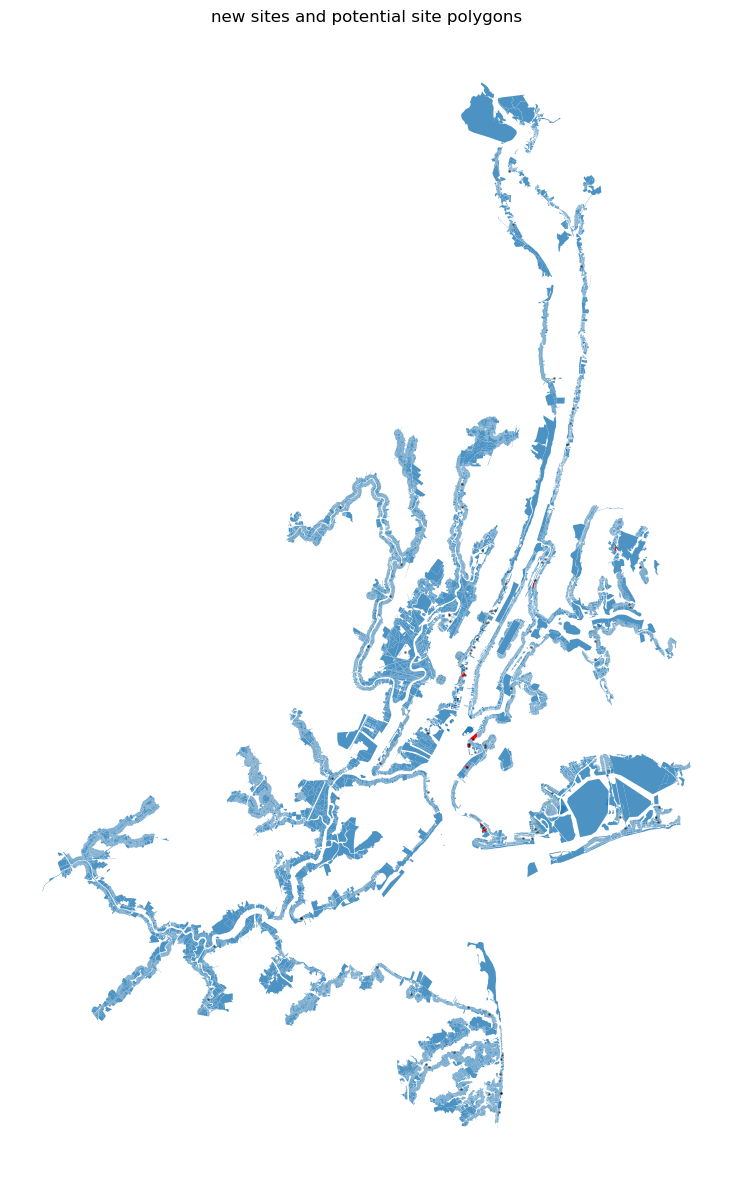

In [244]:
# plot to see and document changes

fig, ax = plt.subplots(figsize = (12,12))

need_poly_join.plot(ax = ax, markersize = 1, color = 'black', alpha = .4, zorder = 3) # new site points)
new_site_polys.plot(ax = ax, color = 'red', zorder = 2) # new site polys to add
pot_polys.plot(ax = ax, alpha = .8, zorder = 1) # original potential polygon dataset 

ax.axis('off')
plt.title('new sites and potential site polygons');
fig.tight_layout()
plt.savefig('/Users/saraeichner/Dropbox/hudson_access_project/gis/poly_processing/plots/new_sites_+_pot_polys.pdf')

* * * * 
* * * * 

Below script was used to update the potential polygon dataset to make it easier to use
* * * * 

* * * * 
* * * * 

(-8315422.248238324, -8201866.672814732, 4871020.025047208, 5071450.664588127)

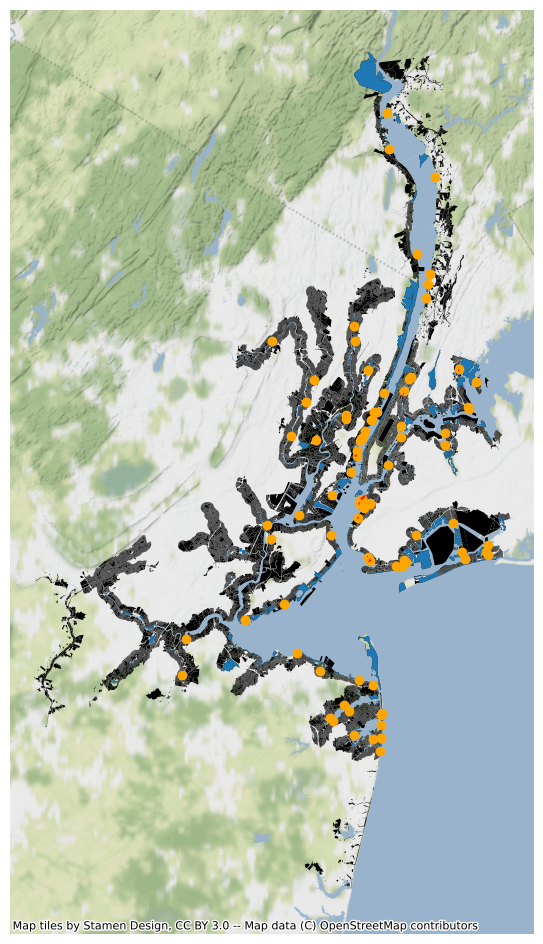

In [46]:
# find how many rows in add_to_hap_polys gdf
# add_to_hap_polys.shape
import contextily as cx
fig,ax = plt.subplots(figsize=(12,12))
pot_polys.to_crs(3857).plot( ax=ax , zorder = 1, color = 'black')
st_polys.to_crs(3857).plot( ax=ax , zorder = 2)
need_poly_join.to_crs(3857).plot( ax=ax, zorder = 3 , color = 'orange' )
add_to_hap_polys.to_crs(3857).plot( ax=ax, zorder = 4 , color = 'red' )


cx.add_basemap( ax, source=cx.providers.Stamen.TerrainBackground )
plt.axis('off')


## fix the gaps in the potential polygon dataset
this was done before processing data to find and subset new site polygons for recent data additions

#### why are there missing shoreline polygons in NYC and westchester county? 
Read in old data and review,
- (done in qgis) make a new quarter mile buffer to reduce the size of this file
    - clip water to project extent
    - create dissolved 1/4 mile buffer 
    - do the same for the bronx river
    - create 1/4 mile buffer  
    - merge 2 buffers
- select all potential polys that intersect with buffer and save as new potential polygon set in progress
- select all polys in 1/4 mile buffer from NYC pluto + Westchester tax lots
- intersect with potential polys to find all that don't overlap 
- add those to potential polygonss
- save new file for future site polygon needs 


In [48]:
# read in shapefile /Users/saraeichner/Dropbox/hudson_access_project/gis/poly_processing/quartermilebuffer_complete_4326.shp
buffer = gpd.read_file('/Users/saraeichner/Dropbox/hudson_access_project/gis/poly_processing/quartermilebuffer_complete_4326.shp')

In [ ]:
# find the crs of 'pot_polys'
pot_polys.crs # EPSG:4326
buffer.crs # EPSG:4326

In [ ]:
print(pluto.crs)

In [55]:
new_site_polygons_part1 = gpd.overlay(pot_polys, buffer, how='intersection')


(-74.60284240910632, -73.68318698051876, 40.24239174025013, 41.3805933097941)

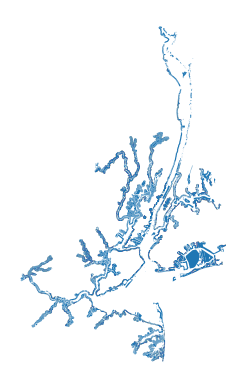

In [57]:
new_site_polygons_part1.plot()
plt.axis('off')

#### read in data 
- NYC pluto
- westchester tax lots 


In [58]:
w_polys = gpd.read_file('/Users/saraeichner/Dropbox/hudson_access_project/gis/County_TaxLots_PossiblePublicAccessSites/WestchesterCounty_possible_public_access_sites.shp')
pluto = gpd.read_file('/Users/saraeichner/Dropbox/hudson_access_project/hap_data/processing/site_poly/tax_lots/NYC/nyc_mappluto_22v3_1_shp/MapPLUTO.shp')
w_taxlots = gpd.read_file('/Users/saraeichner/Downloads/Tax_Parcels.geojson')


(-74.00505826921209,
 -73.45684690032857,
 40.852505337592746,
 41.390804093625114)

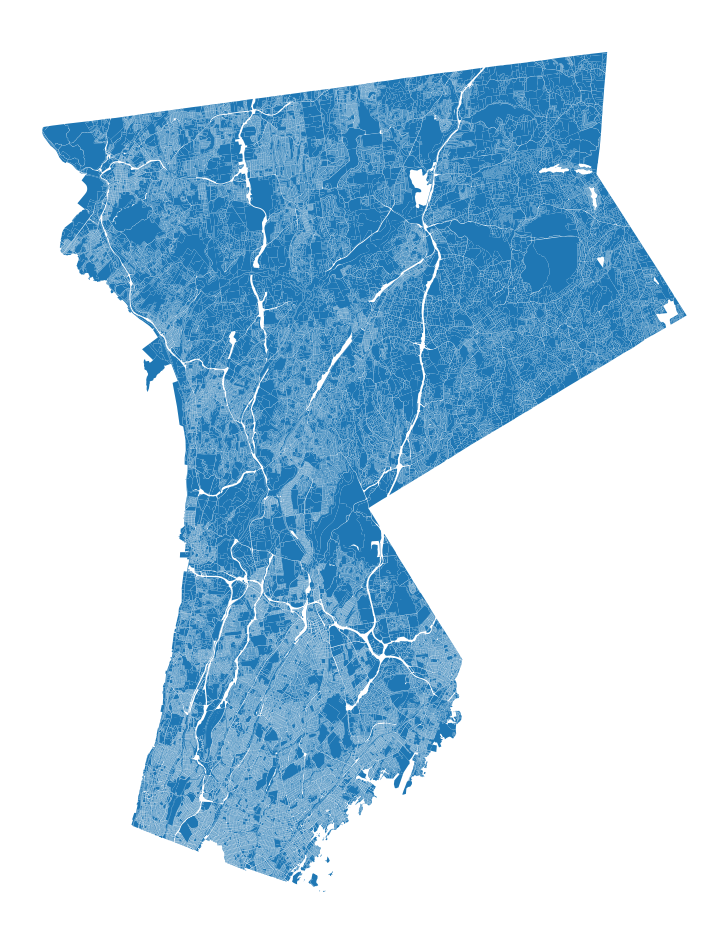

In [81]:
fig,ax = plt.subplots(figsize=(12,12))
w_taxlots.plot(ax=ax)
plt.axis('off')

In [82]:
w_taxlots.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## run the next cell next 

(905418.5751130104, 1075046.302539158, 112410.87609274387, 280449.2929207563)

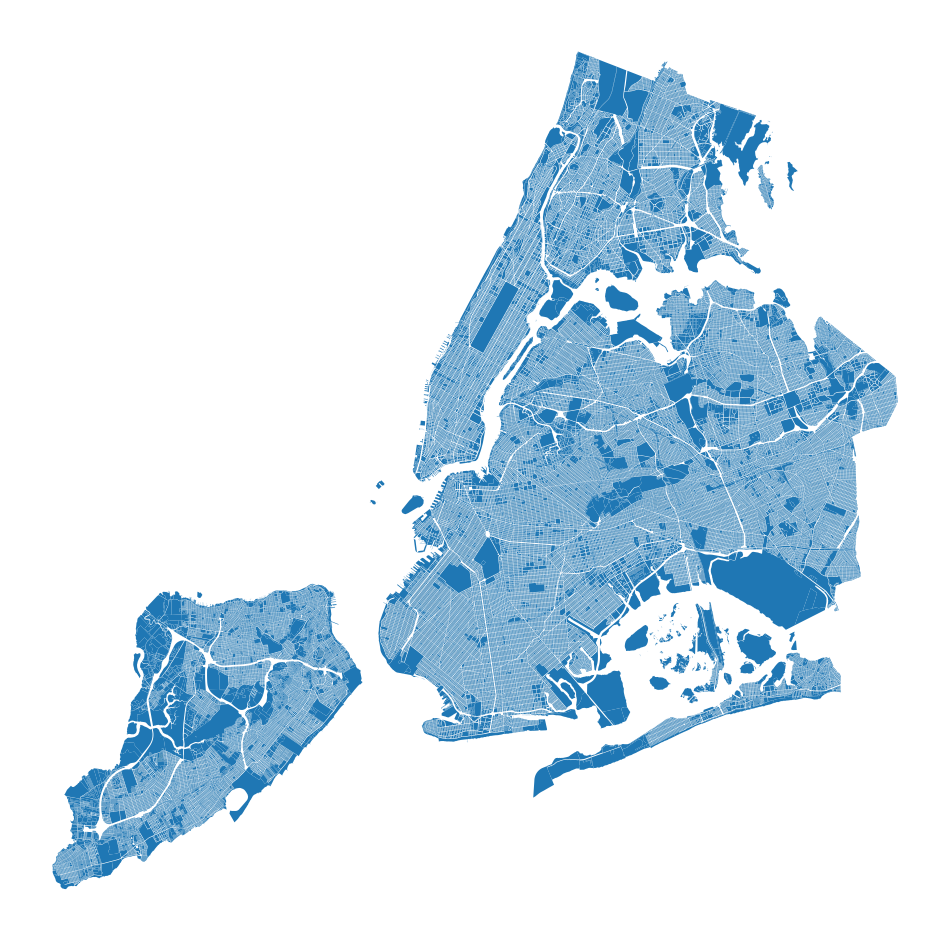

In [64]:
fig,ax = plt.subplots(figsize=(12,12))
pluto.plot( ax=ax , zorder = 1)

plt.axis('off')


In [ ]:
buffer.crs

In [ ]:
buffer2263 = buffer.to_crs(2263)
buffer2263.crs

In [78]:
# pluto_qtrm = pluto[pluto.intersects(buffer2263)] # indices of two geoseries are different
pluto_qtrm = gpd.sjoin(pluto, buffer2263, predicate='intersects', how='inner')

/Applications/anaconda3/envs/geospatial2023/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


(905757.4875749111, 1067929.1408392428, 112410.87609274387, 280449.2929207563)

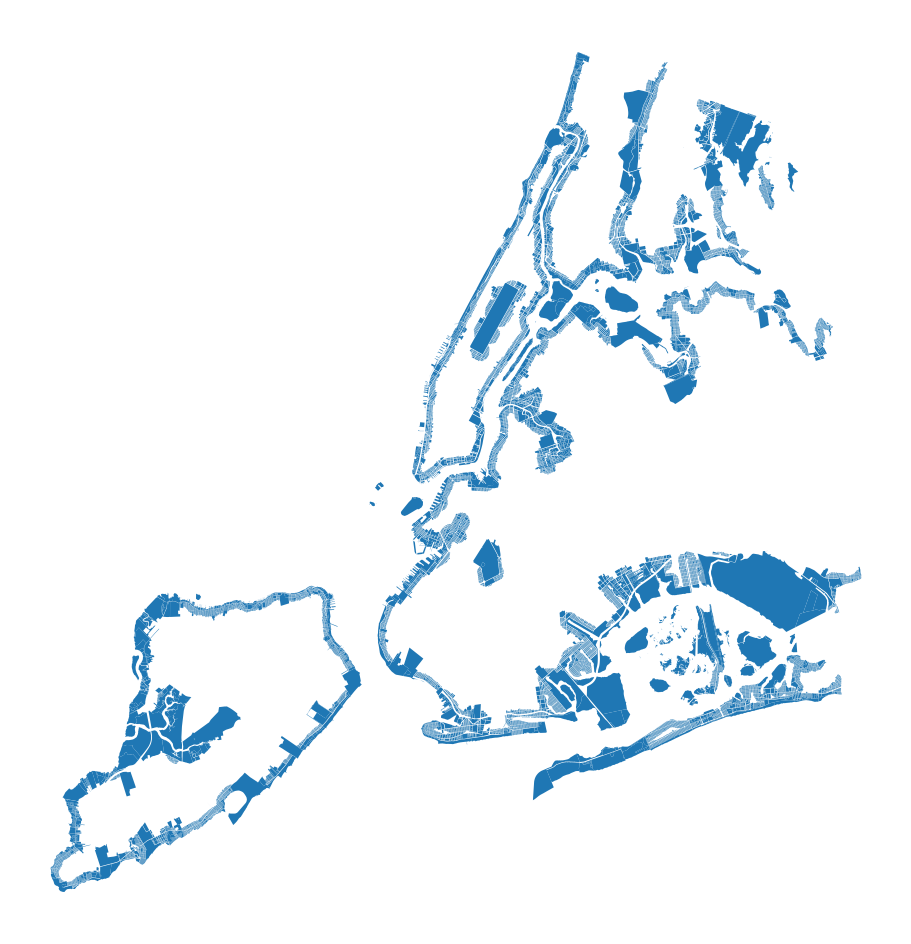

In [79]:

fig,ax = plt.subplots(figsize=(12,12))
pluto_qtrm.plot( ax=ax , zorder = 1)

plt.axis('off')

In [ ]:
westchester_taxlots_qtrm = gpd.sjoin(w_taxlots, buffer, predicate='intersects', how='inner')

In [86]:
new_site_polygons_part1 = gpd.sjoin(pot_polys, buffer, op='intersects', how='inner')

/Applications/anaconda3/envs/geospatial2023/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [90]:
# write new_site_polygons_part1 to geojson 
new_site_polygons_part1.to_file("/Users/saraeichner/Dropbox/hudson_access_project/gis/poly_processing/new_site_polygons_part1.geojson", driver='GeoJSON')
westchester_taxlots_qtrm.to_file("/Users/saraeichner/Dropbox/hudson_access_project/gis/poly_processing/westchester_tx_quarterm_buffer_select.geojson", driver='GeoJSON')
pluto_qtrm.to_file("/Users/saraeichner/Dropbox/hudson_access_project/gis/poly_processing/pluto_quarterm_buffer_select.geojson", driver='GeoJSON')


(-74.62508793, -73.68212767, 40.23934108, 41.39042332)

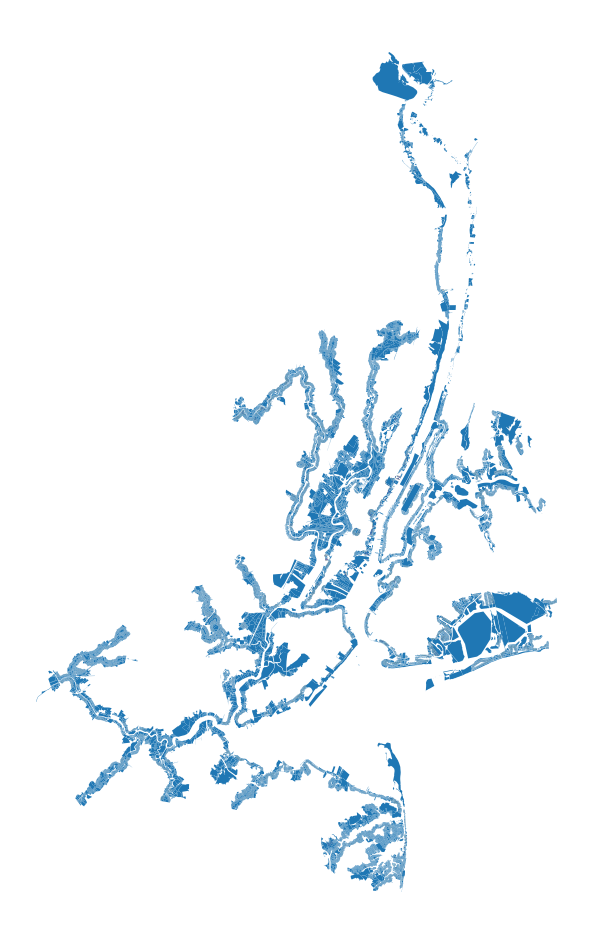

In [88]:
fig,ax = plt.subplots(figsize=(12,12))
#westchester_taxlots_qtrm.plot( ax=ax , zorder = 1)
new_site_polygons_part1.plot(ax=ax)

plt.axis('off')

(-73.99028778566685, -73.76702705477865, 40.85923721401458, 41.348191961209636)

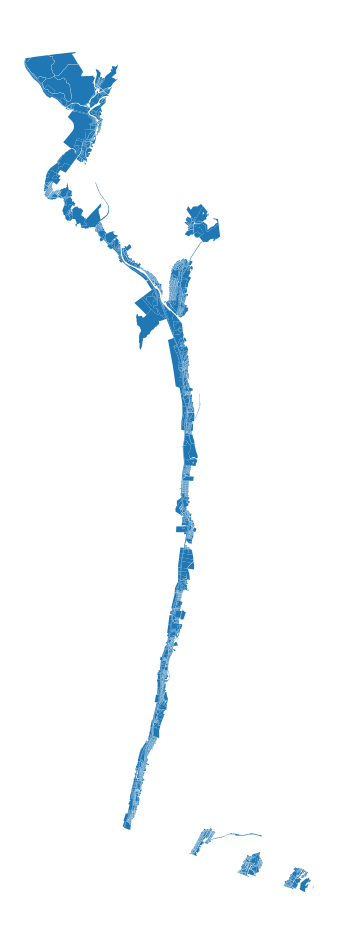

In [89]:

fig,ax = plt.subplots(figsize=(12,12))
westchester_taxlots_qtrm.plot( ax=ax)

plt.axis('off')

### merge tax lots within qtr mile buffer (NYC + westchester)

In [95]:
print(new_site_polygons_part1.crs)
print(westchester_taxlots_qtrm.crs)
print(pluto_qtrm.crs)


epsg:4326
epsg:4326
EPSG:4326


In [96]:
# concatenate 'westchester_taxlots_qtrm' and 'pluto_qtrm' to create 'taxlots_westchester_nyc_qtrm'
taxlots_westchester_nyc_qtrm = pd.concat([westchester_taxlots_qtrm, pluto_qtrm], axis=0, ignore_index=True)

(-74.28229662177732, -73.69845027249687, 40.45441308735962, 41.36746930057416)

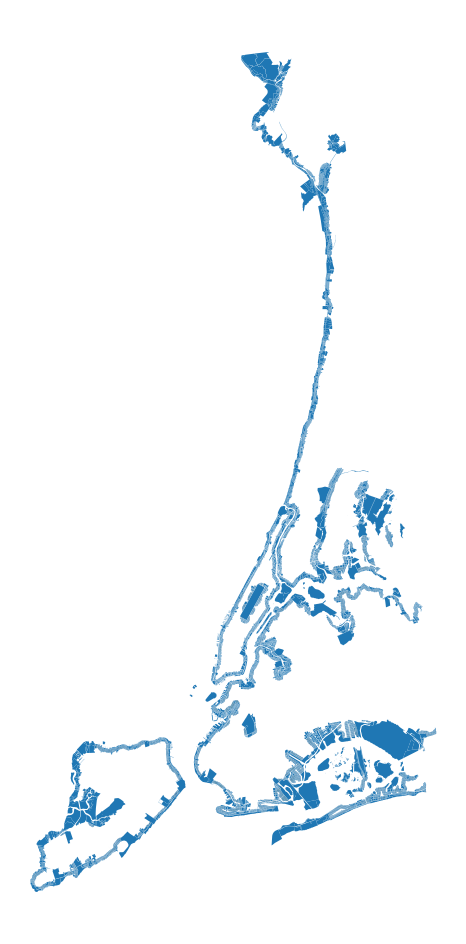

In [97]:
fig,ax = plt.subplots(figsize=(12,12))
taxlots_westchester_nyc_qtrm.plot( ax=ax)
plt.axis('off')

In [ ]:
add_to_pot_poly = gpd.sjoin(taxlots_westchester_nyc_qtrm, buffer, predicate='intersects', how='inner')

### find polygons that are not in the potential polgyon dataset and add to pot_polys


In [98]:
# add a column called 'match' to the new pot_poly data dataset with  a 1 for all rows
# then when checkign against new taxlots in NYC and westchester add that column to data, and 1 will be there only if they match. Subest data to 0 or nan in that column to add to the pot_polys

new_site_polygons_part1['match'] = 1
new_site_polygons_part1.head()

site_name       act_codes  \
0                                   Ferry Point Park            FISH   
1                                  Calvert Vaux Park       MPBL,FISH   
2                                   Great Kills Park  MPBL,HPBL,FISH   
3  East River Esplanade And Bikeway (E 90th St - ...       FISH,HPBL   
4                             Flushing Bay Promenade  FISH,MPBL,HPBL   

                                             address site_id hap_site prop_id  \
0  Hutchinson River Parkway by the Whitestone Bri...       2      yes    None   
1                Shore Rd-Bay 46th St.  Bensonhurst,       3      yes    None   
2  192 Buffalo St,  Staten Island,Hylan Blvd & Bu...       6      yes    None   
3         E 96th St, Manhattan,FDR Dr. near 107th St     114      yes    None   
4  Flushing Bay Promenade bet. Worlds Fair Marina...      10      yes    None   

  dataset  name owner_tax                            layer  \
0    None  None      None  HAP_site_polys_cleanedup_6-4-23   
1    None  None      None  HAP_site_polys_cleanedup_6-4-23   
2    None  None      None  HAP_site_polys_cleanedup_6-4-23   
3    None  None      None  HAP_site_polys_cleanedup_6-4-23   
4    None  None      None  HAP_site_polys_cleanedup_6-4-23   

                                                path potent_id  \
0  /Users/saraeichner/Dropbox/hudson_access_proje...      None   
1  /Users/saraeichner/Dropbox/hudson_access_proje...      None   
2  /Users/saraeichner/Dropbox/hudson_access_proje...      None   
3  /Users/saraeichner/Dropbox/hudson_access_proje...      None   
4  /Users/saraeichner/Dropbox/hudson_access_proje...      None   

                                            geometry  add_to_hap_polys  \
0  MULTIPOLYGON (((-73.82654 40.81132, -73.82668 ...             False   
1  MULTIPOLYGON (((-73.98779 40.57983, -73.98779 ...             False   
2  MULTIPOLYGON (((-74.11549 40.54746, -74.11554 ...             False   
3  MULTIPOLYGON (((-73.92895 40.80031, -73.92894 ...             False   
4  MULTIPOLYGON (((-73.86275 40.76676, -73.86272 ...             False   

   index_right  id    FID  TribsRivOc  match  
0            0   0  68178           1      1  
1            0   0  68178           1      1  
2            0   0  68178           1      1  
3            0   0  68178           1      1  
4            0   0  68178           1      1

In [100]:
#new_site_polygons_part1['index_old'] = new_site_polygons_part1['index_right']
new_site_polygons_part1 = new_site_polygons_part1.drop(['index_right'], axis=1)

In [103]:
taxlots_westchester_nyc_qtrm = taxlots_westchester_nyc_qtrm.drop(['index_right'], axis=1)

In [102]:
taxlots_westchester_nyc_qtrm.head()

MUNNAME    SWIS                   SBL   PRINTKEY          PROPADDRESS  \
0  Cortlandt  552289  02201600020010000000  22.16-2-1       54 ROA HOOK RD   
1  Cortlandt  552289  02201600020020000000  22.16-2-2       56 ROA HOOK RD   
2  Cortlandt  552289  02201600030010000000  22.16-3-1       42 ROA HOOK RD   
3  Cortlandt  552289  02201600030020000000  22.16-3-2       46 ROA HOOK RD   
4  Cortlandt  552289  02201200010010000000  22.12-1-1  5766 ALBANY POST RD   

  PROPAPT PROPERTYCLASS CITYTOWN_NAME CITYTOWN_SWIS  OBJECTID_12  \
0    None           210     Cortlandt        552200        347.0   
1    None           220     Cortlandt        552200        348.0   
2    None           314     Cortlandt        552200        815.0   
3    None           484     Cortlandt        552200        816.0   
4    None           220     Cortlandt        552200       1152.0   

         AREA_1  TAXMAPSwcparcelsLEN  \
0  6.202536e+08        187945.130934   
1  6.202536e+08        187945.130934   
2  6.202536e+08        187945.130934   
3  6.202536e+08        187945.130934   
4  6.202536e+08        187945.130934   

                                            geometry  index_right  id    FID  \
0  POLYGON ((-73.93146 41.30270, -73.93171 41.302...            0   0  68178   
1  POLYGON ((-73.93171 41.30288, -73.93173 41.302...            0   0  68178   
2  POLYGON ((-73.93027 41.30358, -73.93013 41.303...            0   0  68178   
3  POLYGON ((-73.93027 41.30358, -73.93048 41.303...            0   0  68178   
4  POLYGON ((-73.93155 41.30927, -73.93157 41.309...            0   0  68178   

   TribsRivOc Borough  Block  Lot  CD BCT2020 BCTCB2020 CT2010 CB2010  \
0           1     NaN    NaN  NaN NaN     NaN       NaN    NaN    NaN   
1           1     NaN    NaN  NaN NaN     NaN       NaN    NaN    NaN   
2           1     NaN    NaN  NaN NaN     NaN       NaN    NaN    NaN   
3           1     NaN    NaN  NaN NaN     NaN       NaN    NaN    NaN   
4           1     NaN    NaN  NaN NaN     NaN       NaN    NaN    NaN   

  SchoolDist  Council  ZipCode FireComp  PolicePrct  HealthCent  HealthArea  \
0        NaN      NaN      NaN      NaN         NaN         NaN         NaN   
1        NaN      NaN      NaN      NaN         NaN         NaN         NaN   
2        NaN      NaN      NaN      NaN         NaN         NaN         NaN   
3        NaN      NaN      NaN      NaN         NaN         NaN         NaN   
4        NaN      NaN      NaN      NaN         NaN         NaN         NaN   

  Sanitboro SanitDistr SanitSub Address ZoneDist1 ZoneDist2 ZoneDist3  \
0       NaN        NaN      NaN     NaN       NaN       NaN       NaN   
1       NaN        NaN      NaN     NaN       NaN       NaN       NaN   
2       NaN        NaN      NaN     NaN       NaN       NaN       NaN   
3       NaN        NaN      NaN     NaN       NaN       NaN       NaN   
4       NaN        NaN      NaN     NaN       NaN       NaN       NaN   

  ZoneDist4 Overlay1 Overlay2 SPDist1 SPDist2 SPDist3 LtdHeight SplitZone  \
0       NaN      NaN      NaN     NaN     NaN     NaN       NaN       NaN   
1       NaN      NaN      NaN     NaN     NaN     NaN       NaN       NaN   
2       NaN      NaN      NaN     NaN     NaN     NaN       NaN       NaN   
3       NaN      NaN      NaN     NaN     NaN     NaN       NaN       NaN   
4       NaN      NaN      NaN     NaN     NaN     NaN       NaN       NaN   

  BldgClass LandUse  Easements OwnerType OwnerName  LotArea  BldgArea  \
0       NaN     NaN        NaN       NaN       NaN      NaN       NaN   
1       NaN     NaN        NaN       NaN       NaN      NaN       NaN   
2       NaN     NaN        NaN       NaN       NaN      NaN       NaN   
3       NaN     NaN        NaN       NaN       NaN      NaN       NaN   
4       NaN     NaN        NaN       NaN       NaN      NaN       NaN   

   ComArea  ResArea  OfficeArea  RetailArea  GarageArea  StrgeArea  \
0      NaN      NaN         NaN         NaN         NaN        NaN   
1      NaN

In [104]:
nyc_wetchester_match = gpd.sjoin(taxlots_westchester_nyc_qtrm, new_site_polygons_part1, how="left", predicate='intersects')
nyc_wetchester_match_copy = nyc_wetchester_match.fillna(0).reset_index()

In [113]:
# subset the polygons to ones that do not intersect with the potential polygons
no_match_polys = nyc_wetchester_match_copy[(nyc_wetchester_match_copy['match']==0)]
no_match_polys.head()

index    MUNNAME    SWIS                   SBL    PRINTKEY  \
5      5  Cortlandt  552289  02201200020080000000   22.12-2-8   
6      6  Cortlandt  552289  02201200020090000000   22.12-2-9   
7      7  Cortlandt  552289  02201200020100000000  22.12-2-10   
8      8  Cortlandt  552289  02201200020110000000  22.12-2-11   
9      9  Cortlandt  552289  02201200020120000000  22.12-2-12   

          PROPADDRESS PROPAPT PROPERTYCLASS CITYTOWN_NAME CITYTOWN_SWIS  \
5  51 SPROUT BROOK RD       0           210     Cortlandt        552200   
6     56 DORIS LEE DR       0           210     Cortlandt        552200   
7  49 SPROUT BROOK RD       0           311     Cortlandt        552200   
8  45 SPROUT BROOK RD       0           432     Cortlandt        552200   
9  39 SPROUT BROOK RD       0           210     Cortlandt        552200   

   OBJECTID_12        AREA_1  TAXMAPSwcparcelsLEN  \
5       1155.0  6.202536e+08        187945.130934   
6       1156.0  6.202536e+08        187945.130934   
7       1157.0  6.202536e+08        187945.130934   
8       1158.0  6.202536e+08        187945.130934   
9       1159.0  6.202536e+08        187945.130934   

                                            geometry  id_left  FID_left  \
5  POLYGON ((-73.92498 41.31157, -73.92500 41.311...        0     68178   
6  POLYGON ((-73.92604 41.31115, -73.92729 41.311...        0     68178   
7  POLYGON ((-73.92541 41.31062, -73.92611 41.311...        0     68178   
8  POLYGON ((-73.92630 41.31082, -73.92652 41.310...        0     68178   
9  POLYGON ((-73.92652 41.31061, -73.92704 41.310...        0     68178   

   TribsRivOc_left Borough  Block  Lot   CD BCT2020 BCTCB2020 CT2010 CB2010  \
5                1       0    0.0  0.0  0.0       0         0      0      0   
6                1       0    0.0  0.0  0.0       0         0      0      0   
7                1       0    0.0  0.0  0.0       0         0      0      0   
8                1       0    0.0  0.0  0.0       0         0      0      0   
9                1       0    0.0  0.0  0.0       0         0      0      0   

  SchoolDist  Council  ZipCode FireComp  PolicePrct  HealthCent  HealthArea  \
5          0      0.0      0.0        0         0.0         0.0         0.0   
6          0      0.0      0.0        0         0.0         0.0         0.0   
7          0      0.0      0.0        0         0.0         0.0         0.0   
8          0      0.0      0.0        0         0.0         0.0         0.0   
9          0      0.0      0.0        0         0.0         0.0         0.0   

  Sanitboro SanitDistr SanitSub Address ZoneDist1 ZoneDist2 ZoneDist3  \
5         0          0        0       0         0         0         0   
6         0          0        0       0         0         0         0   
7         0          0        0       0         0         0         0   
8         0          0        0       0         0         0         0   
9         0          0        0       0         0         0         0   

  ZoneDist4 Overlay1 Overlay2 SPDist1 SPDist2  SPDist3 LtdHeight SplitZone  \
5         0        0        0       0       0        0         0         0   
6         0        0        0       0       0        0         0         0   
7         0        0        0       0       0        0         0         0   
8         0        0        0       0       0        0         0         0   
9         0        0        0       0       0        0         0         0   

  BldgClass LandUse  Easements OwnerType OwnerName  LotArea  BldgArea  \
5         0       0        0.0         0         0      0.0       0.0   
6         0       0        0.0         0         0      0.0       0.0   
7         0       0        0.0         0         0      0.0       0.0   
8         0       0        0.0         0         0      0.0       0.0   
9         0       0        0.0         0         0      0.0       0.0   

   ComArea  ResArea  OfficeArea  RetailArea  GarageArea  StrgeArea  \
5      0.0      0.0     

In [105]:
# check the data for matching poly count -- it should be a small minority of lots, no match polys should match the number of 'match' == 0
print(len(nyc_wetchester_match_copy[nyc_wetchester_match_copy['match'] == 1])) ##542
print(len(nyc_wetchester_match_copy[nyc_wetchester_match_copy['match'] == 0])) ##20563
print(len(no_match_polys))

279277
13020


In [115]:
# save the no_match_polys to a shapefile
no_match_polys.to_file("/Users/saraeichner/Dropbox/hudson_access_project/gis/poly_processing/missing_pot_polys.geojson", driver='GeoJSON')

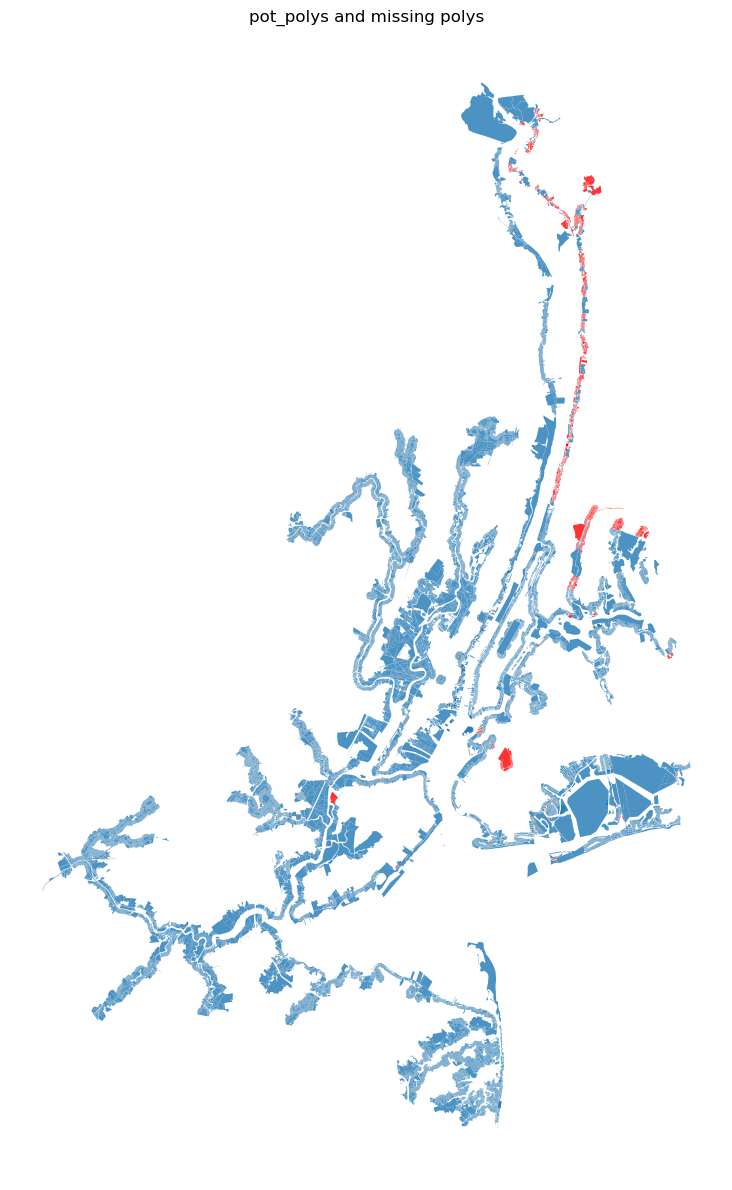

In [118]:
# plot to see how much overlap there is between the two gdfs
# new_potential_polygons
fig, ax = plt.subplots(figsize = (12,12))
no_match_polys.plot(ax = ax, color = 'red', alpha = .8, zorder = 2)
new_site_polygons_part1.plot(ax = ax, alpha = .8, zorder = 1)

ax.axis('off')
plt.title('pot_polys and missing polys');
fig.tight_layout()
plt.savefig('/Users/saraeichner/Dropbox/hudson_access_project/gis/poly_processing/plots/missing_pot_polys.pdf')

In [119]:
# concatenate 'no_match_polys' with 'new_site_polygons_part1'
new_potential_polygons = pd.concat([no_match_polys, new_site_polygons_part1], ignore_index=True)

In [121]:
print(len(new_potential_polygons))
print(len(no_match_polys))
print(len(new_site_polygons_part1))


298965
13020
285945


In [125]:
print(pot_polys.columns.tolist())

['site_name', 'act_codes', 'address', 'site_id', 'hap_site', 'prop_id', 'dataset', 'name', 'owner_tax', 'layer', 'path', 'potent_id', 'geometry', 'add_to_hap_polys']


In [123]:
# simplify polygon dataset -- remove unnecessary columns
# print column names

print(new_potential_polygons.columns.tolist())

['index', 'MUNNAME', 'SWIS', 'SBL', 'PRINTKEY', 'PROPADDRESS', 'PROPAPT', 'PROPERTYCLASS', 'CITYTOWN_NAME', 'CITYTOWN_SWIS', 'OBJECTID_12', 'AREA_1', 'TAXMAPSwcparcelsLEN', 'geometry', 'id_left', 'FID_left', 'TribsRivOc_left', 'Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010', 'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub', 'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType', 'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal', 'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot', 'ExemptTot', 'YearBuilt', 'YearAl

In [126]:
# reduce columns
columns = [
    'site_name', 'act_codes', 'address', 'site_id', 'hap_site','dataset','name', 'owner_tax','match', 'geometry'
    ]

new_potential_polygons = new_potential_polygons[columns].copy()
new_potential_polygons.tail(6)

site_name       act_codes  \
298959                 Branchport Park            FISH   
298960              Maxwell Place Park            MPBL   
298961  Fdr Veterans Memorial Hospital            FISH   
298962            Oscawana Island Park            FISH   
298963       Louis Valentino, Jr. Park  MPBL,HPBL,FISH   
298964                River Barge Park            MPBL   

                                           address site_id hap_site dataset  \
298959               Atlantic Ave & Branchport Ave  600753     None    None   
298960              Maxwell Place Park, Hoboken NJ  601699     None    None   
298961         RT-9A in Montrose, West on Dutch St  645352     None    None   
298962             RT-9A, West in Furnance Dock Rd  646671     None    None   
298963  Coffey Street End,  Brooklyn,Coffey Street   68314     None    None   
298964                                        None      NA     None    None   

        name owner_tax  match  \
298959  None      None    1.0   
298960  None      None    1.0   
298961  None      None    1.0   
298962  None      None    1.0   
298963  None      None    1.0   
298964  None      None    1.0   

                                                 geometry  
298959  MULTIPOLYGON (((-74.00445 40.31064, -74.00446 ...  
298960  MULTIPOLYGON (((-74.02293 40.74928, -74.02294 ...  
298961  MULTIPOLYGON (((-73.93770 41.23320, -73.93771 ...  
298962  MULTIPOLYGON (((-73.92601 41.22673, -73.92605 ...  
298963  MULTIPOLYGON (((-74.01811 40.67861, -74.01812 ...  
298964  MULTIPOLYGON (((-74.05771 40.80703, -74.05772 ...

In [127]:
# save the new_pot_polys to a shapefile
new_potential_polygons.to_file("/Users/saraeichner/Dropbox/hudson_access_project/hap_data/merged_site_data/potential_site_polygons_08162023.geojson", driver='GeoJSON')

* * * * * 
* * * * * 

### end of filling potential polygon gaps
* * * * * 
* * * * * 


(585612.1652500003, 607067.0283500005, 4523685.6335350005, 4578259.307965)

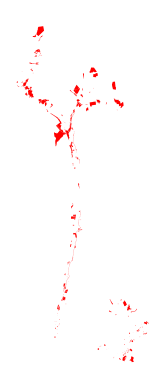

In [59]:
w_polys.plot(color='red')
plt.axis('off')

In [ ]:
### count the NA site_ids

add_to_hap_polys['site_id'].isna().sum() 

### see what the new polys look like and how the intersect with new/recent site points

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
st_polys.head()

AttributeError: 'AxesSubplot' object has no attribute 'head'

In [17]:
m = folium.Map(
    location=[
        stpts['y'].mean(), 
        stpts['x'].mean()
    ], 
    zoom_start=10,
)
# add the add_to_hap_polys as a layer
# color = green for the polygons that are in the add_to_hap_polys
folium.GeoJson(
    add_to_hap_polys,
    name='add_to_hap_polys',
    style_function=lambda x: {"fillColor": "black"}
   

).add_to(m)

# add st_polys as a bottom layer
# color = blue for the polygons that are in the st_polys
folium.GeoJson(
    st_polys,
    name='st_polys',
    style_function=lambda x: {"fillColor": "black"}
).add_to(m)

# folium polygon fill color 
# use green to fill st_polys

# use black to fill add_to_hap_polys
# code to change color of polygons
# https://stackoverflow.com/questions/45493273/folium-geojson-how-to-change-color-of-polygons

#creating a Marker for each point in df_sample. Each point will get a popup with their zip
for row in stpts.itertuples():
        popup_text = f"Site Name: {row.site_name}<br>Activity Codes: {row.act_codes}"
        color = 'blue' if pd.isna(row.Creator) else 'red'
    
        folium.CircleMarker(
            location=[row.y,  row.x],
            radius=1,
            popup=popup_text,
            color=color,  # Change the color of the circle outline
            fill=True,
            fill_color='blue'
        ).add_to(m)
    
m  

ValueError: Cannot render objects with any missing geometries: <AxesSubplot: >

In [24]:
st_polys.shape

(837, 8)

In [25]:
# add or concatenate: add_to_hap_polys to st_polys
st_polys_new = pd.concat([st_polys,add_to_hap_polys],ignore_index=True)


In [26]:
st_polys_new.shape

(856, 15)

In [27]:
# save or write st_polys_new polygons to geojson


st_polys_new.to_file('/Users/saraeichner/Desktop/github/hap/data/hap_site_polys_20230811.geojson', driver='GeoJSON')
